In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


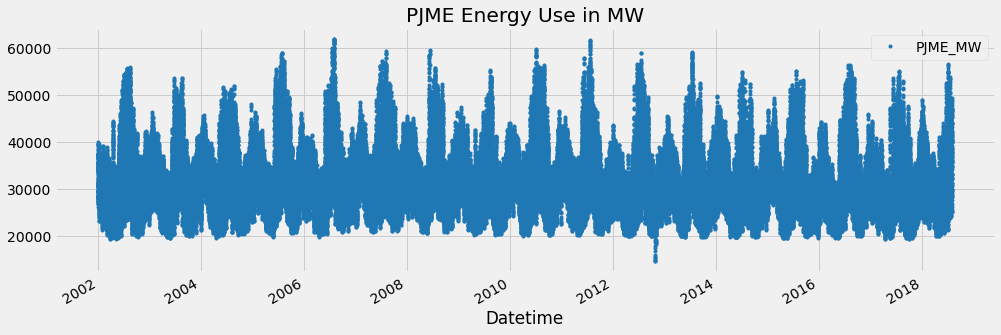

In [4]:
df.plot(style = '.', figsize = (15,5), color = color_pal[0],title= 'PJME Energy Use in MW')
plt.show()

## Outlier Analysis and Removal

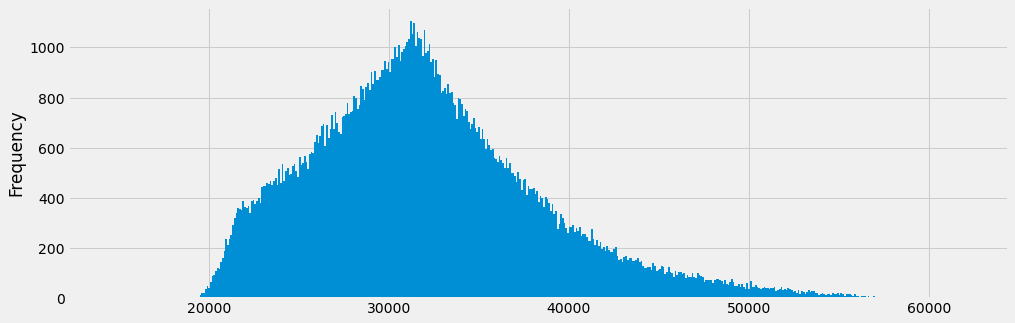

In [7]:
df["PJME_MW"].plot(kind = 'hist', bins = 500, figsize = (15,5))
plt.show()

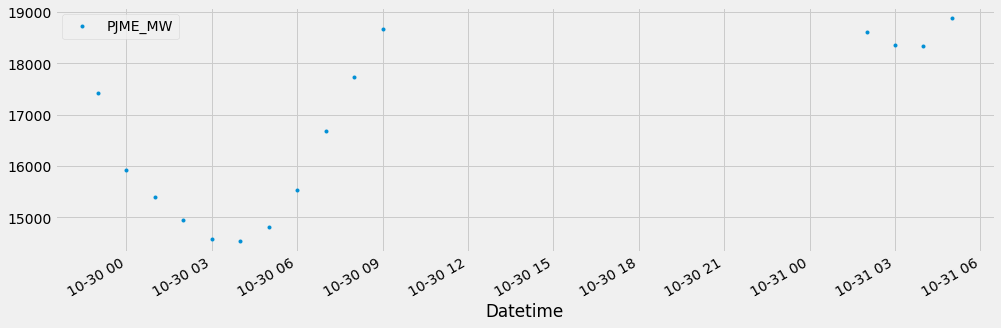

In [10]:
df.query('PJME_MW < 19_000').plot(figsize=(15,5), style = '.')
plt.show()

In [11]:
df = df.query('PJME_MW > 19_000').copy()

## Train and Test Split

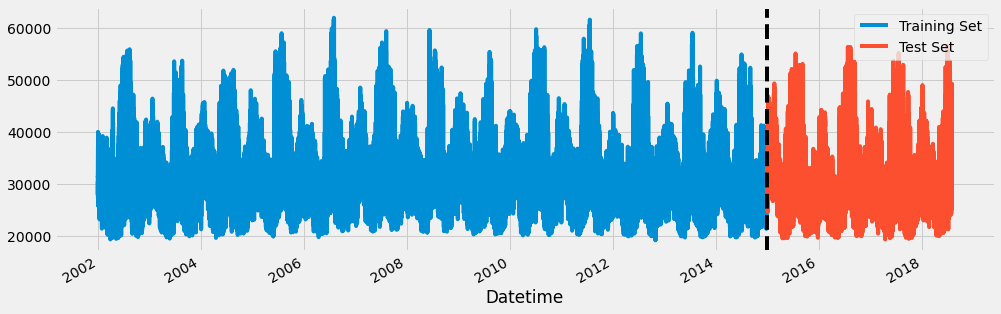

In [13]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5) )
train.plot(ax = ax, label = 'Training Set')
test.plot(ax = ax, label = 'Test Set')
plt.axvline('01-01-2015', color = 'black', ls = '--')
plt.legend(["Training Set", "Test Set"])
plt.show()

## Time Series Cross Validation

In [15]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

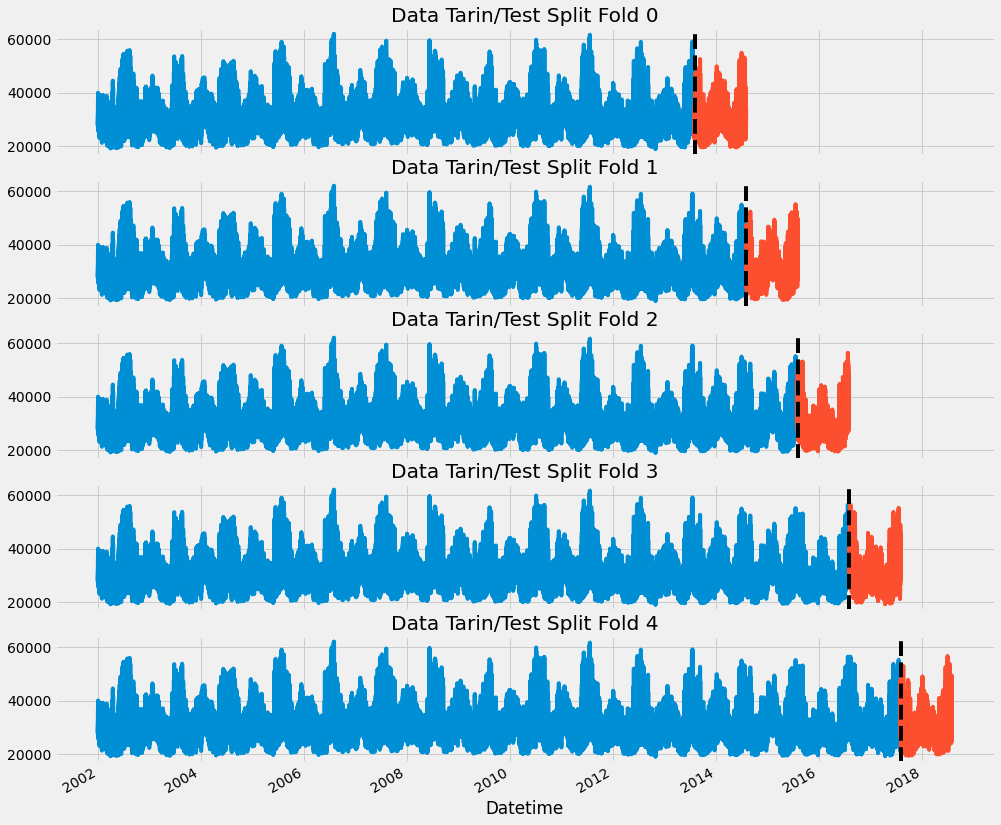

In [21]:
fig, axs = plt.subplots(5,1, figsize=(15,15), sharex = True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["PJME_MW"].plot(ax = axs[fold],
                         label = 'Training Set',
                         title = f'Data Tarin/Test Split Fold {fold}')
    test["PJME_MW"].plot(ax = axs[fold],
                         label = 'Test Set'
                         )
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1

## Forecasting Horizon

In [23]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.day_of_year
    return df

df = create_features(df)

## Lag Features

In [28]:
def add_lags(df):    
    target_map = df["PJME_MW"].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [29]:
df = add_lags(df)

## Train Using Cross Validation

In [31]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['day_of_year', 'hour', 'day_of_week', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:24:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[456]	validation_0-rmse:3349.18480	validation_1-rmse:3761.64093
[16:25:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rmse:5755.14393	validation_1-rmse:5

## Predicting the Future

In [36]:
df = create_features(df)

FEATURES = ['day_of_year', 'hour', 'day_of_week', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[17:03:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [46]:
future = pd.date_range('2018-08-03', '2019-08-01', freq = '1h')
future_df = pd.DataFrame(index = future)
future_df['is_future'] = True
df['is_future'] = False
df_and_future = pd.concat([df,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [49]:
future_w_features = df_and_future.query('is_future').copy()

In [50]:
future_w_features

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3,is_future
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,40666.0,34555.0,34641.0,True


In [51]:
future_w_features["pred"] = reg.predict(future_w_features[FEATURES])

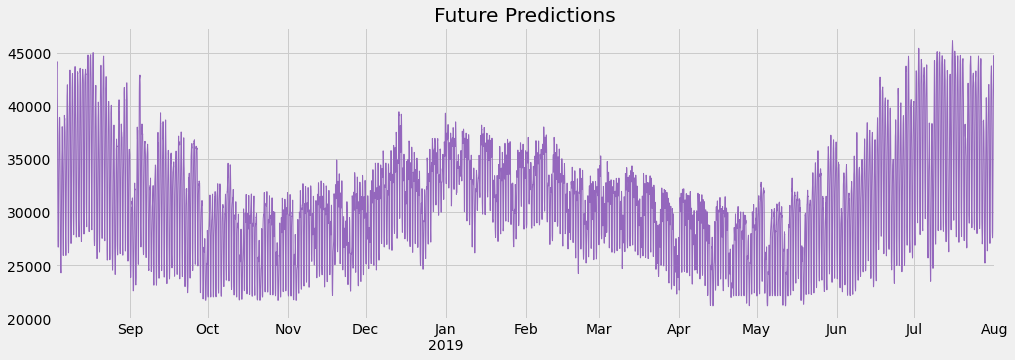

In [53]:
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

## Saving Model for Later

In [54]:
reg.save_model('model.json')

In [55]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

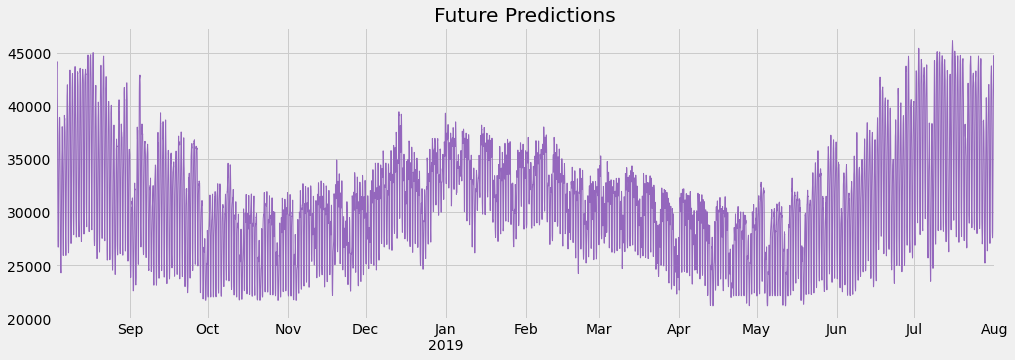

In [56]:
future_w_features["pred"] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()